### Table of contents
1. [Create CAS Connection](#casConnection)
2. [Load Data and Prep](#dataLoadPrep)
3. [Explore Data](#exploreData)
4. [Begin Modeling](#beginModel)
  - [Weights of Evidence](#woe)
  - [Logistic Regression](#lr)
  - [Score Card](#score)

In [79]:
# Import Libraries
import swat
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

### Create a Connection to CAS and Set Library <a name="casConnection"></a>

In [80]:
# Create CAS Connection
host = 'localhost' # GPU Box
portnum = 5570     
conn = swat.CAS(host, portnum, 'sas','Orion123')

In [81]:
# Setup a CAS Library
conn.addcaslib(activeonadd=True,
                     datasource={'srctype':'path'},
                     name='bankDataLib',
                     path='/data/andre_data/abnAmroDemo',
                     subdirectories=True);

NOTE: 'bankDataLib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'bankDataLib'.


### Load Bank Data to CAS and Prep <a name="dataLoadPrep"></a>

In [82]:
# Load Data
data = pd.read_csv('/data/andre_data/abnAmroDemo/cs_accepts_train_small.csv')

In [83]:
# Shape
data.shape

(156915, 27)

In [84]:
# Discretize Categorical Variables
data = pd.get_dummies(data, columns=['title', 'status', 'product', 'resid', 'nat', 'prof', 'car', 'card', 'saving'])

In [85]:
# Impute Median for Missing Values
data['TimeAddress'] = data['TimeAddress'].fillna((data['TimeAddress'].median()))
data['TimeJob'] = data['TimeJob'].fillna((data['TimeJob'].median()))

In [86]:
# Preview Data
pd.set_option('display.max_columns', 500)
data.head()

,_customerID,target,Nchildren,Nhousehold,Age,TimeAddress,TimeJob,tel,NumMyLoan,NumFinLoan,NumLoans,Income,EC_Card,IncLevel,bureau,region,regionLarge,cash,title_H,title_R,status_E,status_G,status_T,status_U,status_V,status_W,product_Cars,product_Dept. Store,product_Electronics,product_Furniture,product_Leisure,product_Others,resid_Lease,resid_Owner,nat_German,nat_Greek,nat_Italian,nat_Other European,nat_Others,nat_Spanish/Portugue,nat_Turkish,nat_Yugoslav,prof_A,prof_B,prof_C,prof_D,prof_E,prof_F,prof_G,prof_H,car_Car,car_Car and Motor,car_Without Vehicle,card_No,card_Yes,saving_No,saving_Yes
0,c000000028,Bad,1,2,26,9.0,27.0,1,0,1,3,10000,0,2,1,4,1,2500,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1
1,c000000032,Bad,0,1,34,42.0,39.0,1,0,1,1,2400,0,1,1,7,1,3000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
2,c000000040,Good,0,2,35,72.0,18.0,2,0,0,0,0,1,0,3,0,0,1500,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
3,c000000051,Good,3,5,34,48.0,60.0,1,0,1,1,0,1,0,1,7,1,700,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0
4,c000000065,Good,0,1,22,216.0,45.0,2,0,0,0,0,1,0,1,4,1,3000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1


In [87]:
# Write Out Dataframe to CAS
data = conn.upload_frame(data, casout=dict(name='data', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table DATA in caslib bankDataLib.
NOTE: The table DATA has been created in caslib bankDataLib from binary data uploaded to Cloud Analytic Services.


In [88]:
conn.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,ModTime,AccessTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,DATA,156915,57,0,utf-8,2018-10-12T19:05:06+00:00,2018-10-12T19:05:06+00:00,2018-10-12T19:05:06+00:00,UTF8,1.854990e+09,1.854990e+09,1.854990e+09,0,0,0,,,0,sas,,2018-10-12T19:05:06+00:00,1.854990e+09


### Explore Data <a name="exploreData"></a>

In [89]:
# View Target Variable Balance
data['target'].freq()

,Column,CharVar,FmtVar,Level,Frequency
0,target,Bad,Bad,1,31704.0
1,target,Good,Good,2,125211.0


In [90]:
# Numeric Variables Summary
conn.CASTable('data').describe()

,Nchildren,Nhousehold,Age,TimeAddress,TimeJob,tel,NumMyLoan,NumFinLoan,NumLoans,Income,EC_Card,IncLevel,bureau,region,regionLarge,cash,title_H,title_R,status_E,status_G,status_T,status_U,status_V,status_W,product_Cars,product_Dept. Store,product_Electronics,product_Furniture,product_Leisure,product_Others,resid_Lease,resid_Owner,nat_German,nat_Greek,nat_Italian,nat_Other European,nat_Others,nat_Spanish/Portugue,nat_Turkish,nat_Yugoslav,prof_A,prof_B,prof_C,prof_D,prof_E,prof_F,prof_G,prof_H,car_Car,car_Car and Motor,car_Without Vehicle,card_No,card_Yes,saving_No,saving_Yes
count,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.00000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000
mean,0.880878,2.483765,35.937559,92.282038,78.329280,1.354077,0.594908,0.495357,0.930211,1956.248287,0.319179,1.01778,1.741045,3.276016,0.733429,2310.432400,0.714100,0.285900,0.005366,0.065469,0.010088,0.287799,0.588465,0.042813,0.079922,0.132562,0.443489,0.304732,0.033317,0.005978,0.720473,0.102992,0.833591,0.014747,0.007743,0.005264,0.022484,0.002556,0.104152,0.009464,0.008336,0.096568,0.076181,0.012931,0.053889,0.009273,0.016098,0.012918,0.768709,0.039333,0.191957,0.658579,0.341421,0.506950,0.393908
std,1.052363,1.343317,11.301323,87.014462,82.825167,0.478234,0.886872,0.499980,1.071630,1586.337523,0.466160,0.77323,0.965084,2.542618,0.442168,2673.116409,0.451843,0.451843,0.073056,0.247352,0.099933,0.452738,0.492113,0.202436,0.271174,0.339102,0.496798,0.460295,0.179465,0.077085,0.448768,0.303949,0.372448,0.120538,0.087654,0.072362,0.148250,0.050488,0.305459,0.096821,0.090919,0.295370,0.265289,0.112975,0.225799,0.095847,0.125852,0.112920,0.421659,0.194388,0.393841,0.474188,0.474188,0.499953,0.488616
min,0.000000,1.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,27.000000,24.000000,21.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,34.000000,60.000000,45.000000,1.000000,0.000000,0.000000,1.000000,2100.000000,0.000000,1.00000,1.000000,3.000000,1.000000,1500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,2.000000,3.000000,43.000000,144.000000,108.000000,2.000000,2.000000,1.000000,1.000000,2800.000000,1.000000,2.00000,3

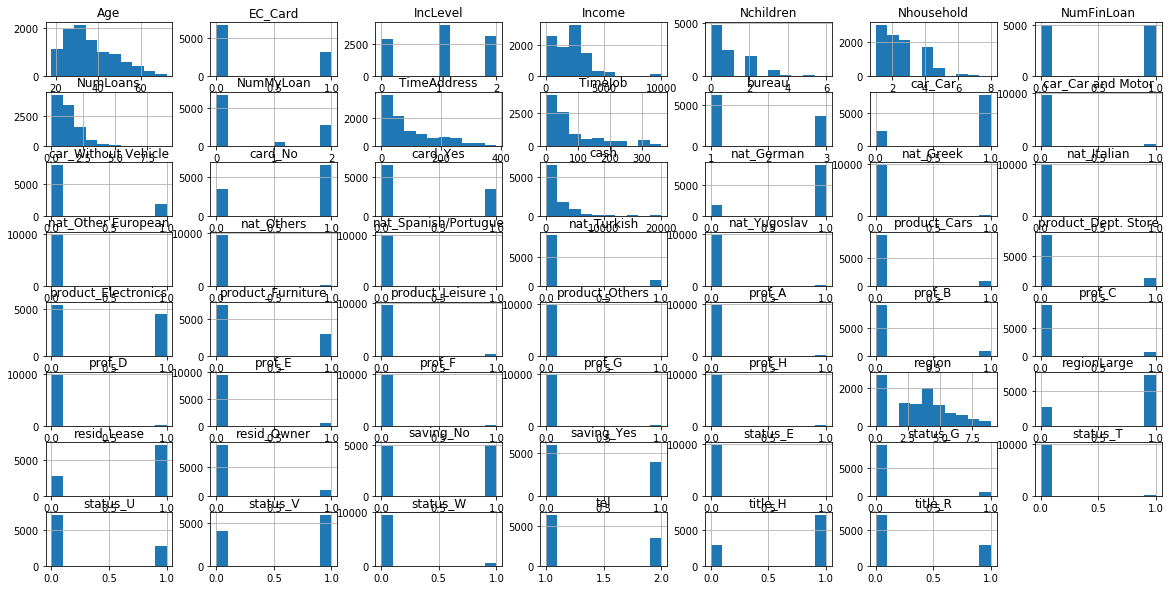

In [91]:
# Visualize Numeric Variable Distributions
data.hist(figsize = (20, 10));

### Begin Modeling <a name="beginModel"></a>

<a name="woe"></a>

<div class="alert alert-info">
<b>Weights of Evidence</b>
</div>

In [92]:
# Load Regression Action Set
conn.loadactionset(actionset='regression')
conn.loadactionset(actionset='dataPreprocess');

NOTE: Added action set 'regression'.
NOTE: Added action set 'dataPreprocess'.


In [93]:
# Set Up Inputs and Target
inputs   = list(data.drop(['target','_customerID'], axis=1))
target   = 'target'

#### Set up Weights of Evidence Transform

In [94]:
# Transform Pipeline
req_packs = []

req_pack1 = dict(name='req1', 
                inputs=inputs,
                targets='target',
                events='Good',
                discretize=dict(method='woe',
                                args = dict(minNBins=3, maxNBins=7)),
                output=dict(scoreWOE=True))

req_packs.append(req_pack1)

In [95]:
# Transform
woeTransform = conn.transform(table=data,
                              requestPackages=req_packs, 
                              casOut=dict(name='woeTransform', replace=True),
                              copyVars = ['target', '_customerID'],
                              outVarsNameGlobalPrefix='woe');

In [96]:
# preview Weights Table
conn.CASTable('woeTransform').head(n=5)

,target,_customerID,woe_Age,woe_bureau,woe_car_Car,woe_car_Car and Motor,woe_car_Without Vehicle,woe_card_No,woe_card_Yes,woe_cash,woe_EC_Card,woe_IncLevel,woe_Income,woe_nat_German,woe_nat_Greek,woe_nat_Italian,woe_nat_Other European,woe_nat_Others,woe_nat_Spanish/Portugue,woe_nat_Turkish,woe_nat_Yugoslav,woe_Nchildren,woe_Nhousehold,woe_NumFinLoan,woe_NumLoans,woe_NumMyLoan,woe_product_Cars,woe_product_Dept. Store,woe_product_Electronics,woe_product_Furniture,woe_product_Leisure,woe_product_Others,woe_prof_A,woe_prof_B,woe_prof_C,woe_prof_D,woe_prof_E,woe_prof_F,woe_prof_G,woe_prof_H,woe_region,woe_regionLarge,woe_resid_Lease,woe_resid_Owner,woe_saving_No,woe_saving_Yes,woe_status_E,woe_status_G,woe_status_T,woe_status_U,woe_status_V,woe_status_W,woe_tel,woe_TimeAddress,woe_TimeJob,woe_title_H,woe_title_R
0,Good,c001942516,-0.864306,0.038464,-0.098866,0.009806,-0.106343,-0.668017,-0.668017,-0.085037,-0.585838,-0.617950,-0.678946,-0.009520,-0.000540,0.005786,-0.00849,-0.015935,0.000991,0.005156,0.005221,0.223703,-0.333864,-0.125904,0.034920,0.081022,-0.016369,0.009531,0.115595,0.076932,0.00279,0.002325,-0.000148,-0.477501,-0.001487,-0.003369,0.029098,0.000558,-0.023165,-0.00142,-0.155021,-0.155021,-0.035029,0.018680,-0.005273,0.007188,-0.000393,0.003533,-0.006368,-0.334430,-0.388041,0.016370,0.116763,-0.316728,-0.020216,0.033008,0.033008
1,Good,c001942518,-0.143014,-0.089431,-0.098866,0.009806,-0.106343,-0.668017,-0.668017,0.088112,0.214584,-0.617950,-0.678946,-0.009520,-0.000540,0.005786,-0.00849,-0.015935,0.000991,0.005156,0.005221,0.223703,0.536068,-0.125904,-0.049761,0.081022,-0.016369,0.009531,-0.098159,-0.190275,0.00279,0.002325,-0.000148,0.043393,-0.001487,-0.003369,0.029098,0.000558,-0.023165,-0.00142,-0.155021,-0.155021,0.013395,0.018680,-0.005273,-0.011120,-0.000393,0.003533,-0.006368,0.630633,0.435747,0.016370,-0.067595,-0.316728,-0.020216,0.033008,0.033008
2,Good,c001942609,-0.002943,0.038464,-0.098866,0.009806,-0.106343,0.260065,0.260065,-0.085037,0.214584,0.432184,0.783027,0.046895,0.035715,0.005786,-0.00849,-0.015935,0.000991,0.005156,0.005221,-0.245962,-0.310262,0.115021,-0.049761,0.081022,-0.016369,0.009531,0.115595,0.076932,0.00279,0.002325,-0.000148,0.043393,-0.001487,-0.003369,0.029098,0.000558,-0.023165,-0.00142,0.119660,0.052918,-0.035029,-0.172407,-0.005273,-0.011120,-0.000393,0.003533,-0.006368,-0.334430,0.435747,-0.419071,-0.067595,0.020547,0.583998,-0.085426,-0.085426
3,Bad,c001942630,0.595045,-0.089431,-0.098866,0.009806,-0.106343,0.260065,0.260065,0.044661,0.214584,-0.617950,0.450691,-0.009520,-0.000540,0.005786,-0.00849,-0.015935,0.000991,0.005156,0.005221,0.223703,0.536068,0.115021,-0.049761,0.081022,-0.016369,0.009531,-0.098159,-0.190275,0.00279,0.002325,-0.000148,0.043393,-0.001487,-0.003369,0.029098,0.000558,-0.023165,-0.00142,-0.155021,-0.155021,0.013395,0.018680,0.005113,0.007188,-0.000393,0.003533,-0.006368,0.630633,0.435747,0.016370,-0.067595,0.100103,0.583998,0.033008,0.033008
4,Good,c001942650,-0.864306,0.038464,-0.098866,0.009806,-0.106343,-0.668017,-0.668017,-0.451330,-0.585838,0.432184,0.450691,-0.009520,-0.000540,0.005786,-0.00849,-0.015935,0.000991,0.005156,0.005221,0.223703,-0.333864,-0.125904,0.313585,0.081022,-0.016369,0.009531,-0.098159,-0.190275,0.00279,0.002325,-0.000148,0.043393,0.017933,-0.003369,0.029098,0.000558,-0.023165,-0.00142,-0.155021,-0.155021,0.013395,0.018680,-0.005273,0.007188,-0.000393,0.003533,-0.006368,-0.334430,-0.388041,0.016370,0.116763,0.100103,0.306499,-0.085426,-0.085426


In [97]:
woeTransform['BinDetails']

,Variable,Transformation,BinId,BinLowerBnd,BinUpperBnd,BinWidth,NInBin,Mean,Std,Min,Max,NEvents,NNonEvents,WOE,IV
0,Age,woe,1,18.00,22.32,4.32,11937,20.763844,1.135849,18.0,22.0,6713.0,5224.0,1.122775,0.249617
1,Age,woe,2,22.32,27.18,4.86,30279,25.041679,1.415304,23.0,27.0,20752.0,9527.0,0.595045,0.160379
2,Age,woe,3,27.18,31.50,4.32,25197,29.517363,1.111066,28.0,31.0,20118.0,5079.0,-0.002943,0.000003
3,Age,woe,4,31.50,35.28,3.78,19398,33.426333,1.135965,32.0,35.0,15907.0,3491.0,-0.143014,0.004842
4,Age,woe,5,35.28,45.54,10.26,39166,40.006741,2.786328,36.0,45.0,33495.0,5671.0,-0.402473,0.071347
5,Age,woe,6,45.54,57.42,11.88,22676,50.934071,3.472852,46.0,57.0,20490.0,2186.0,-0.864306,0.163688
6,Age,woe,7,57.42,72.00,14.58,8262,62.818809,3.630623,58.0,72.0,7736.0,526.0,-1.314781,0.118837
7,bureau,woe,1,1.00,1.02,0.02,98652,1.000000,0.000000,1.0,1.0,78101.0,20551.0,0.038464,0.001882
8,bureau,woe,2,1.02,2.02,1.00,245,2.000000,0.000000,2.0,2.0,0.0,245.0,7.570002,0.116998
9,bureau,woe,3,2.02,3.00,0.98,58018,3.000000,0.000000,3.0,3.0,47110.0,10908.0,-0.089431,0.005757


In [98]:
# Convert Bin Details to Pandas DF for Plotting
woe_bin_df = pd.DataFrame(woeTransform['BinDetails'])

# Time on Job DF
woe_bin_toj = woe_bin_df[woe_bin_df['Variable']=='TimeJob']
woe_bin_age = woe_bin_df[woe_bin_df['Variable']=='Age']
woe_bin_cash = woe_bin_df[woe_bin_df['Variable']=='cash']
woe_bin_taa = woe_bin_df[woe_bin_df['Variable']=='TimeAddress']

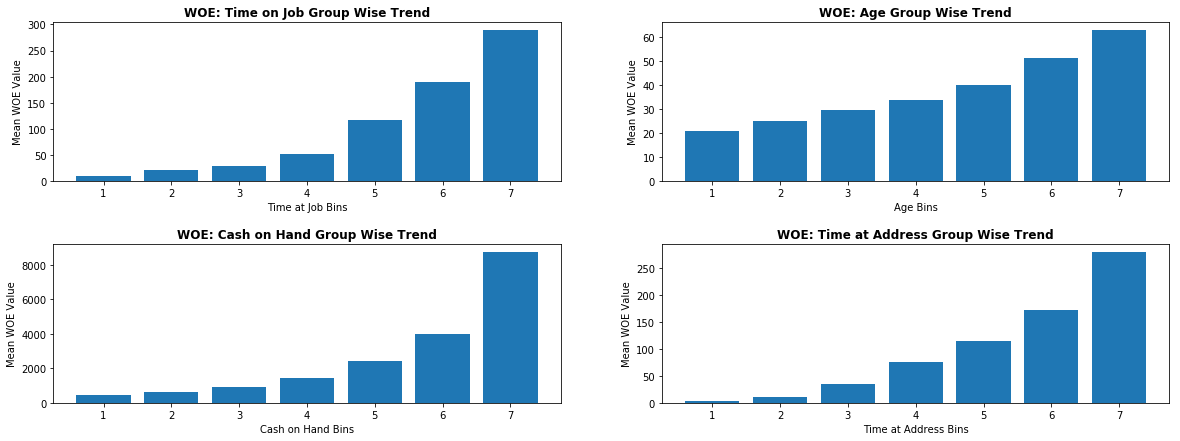

In [99]:
# Plot Examples -  WoE value is a measure of the "strength” of a grouping for separating good and bad credit
plt.figure(figsize=(20,7))
plt.subplots_adjust(hspace=.4)

plt.subplot(2, 2, 1)
plt.bar(woe_bin_toj['BinId'], woe_bin_toj['Mean'])
plt.title('WOE: Time on Job Group Wise Trend', fontweight="bold")
plt.xlabel('Time at Job Bins')
plt.ylabel('Mean WOE Value')

plt.subplot(2, 2, 2)
plt.bar(woe_bin_age['BinId'], woe_bin_age['Mean'])
plt.title('WOE: Age Group Wise Trend', fontweight="bold")
plt.xlabel('Age Bins')
plt.ylabel('Mean WOE Value')

plt.subplot(2, 2, 3)
plt.bar(woe_bin_cash['BinId'], woe_bin_cash['Mean'])
plt.title('WOE: Cash on Hand Group Wise Trend', fontweight="bold")
plt.xlabel('Cash on Hand Bins')
plt.ylabel('Mean WOE Value')

plt.subplot(2, 2, 4)
plt.bar(woe_bin_taa['BinId'], woe_bin_taa['Mean'])
plt.title('WOE: Time at Address Group Wise Trend', fontweight="bold")
plt.xlabel('Time at Address Bins')
plt.ylabel('Mean WOE Value');

<a name="lr"></a>

<div class="alert alert-info">
<b>Logistic Regression</b>
</div>

In [100]:
# Set Empty CAS Table For Model Results
lr_woe_model = conn.CASTable("lr_woe_model",replace = True)

In [197]:
# Concat 'woe_' with Column Names for Inputs
woe_inputs = ['woe_' + str(col)  for col in data.columns[2:]]

lr_woe_model = conn.logistic(table = 'woeTransform',
                             model = dict(depvar=[dict(name=target,
                                                       options=dict(ref='Bad'))],
                                          effects=woe_inputs),
                             selection = dict(method='FORWARD'),
                             store = dict(name='my_lr_Model', replace=True),
                             output = dict(casOut=dict(name='lr_woe_model', replace=True),
                                           copyVars=['target', '_customerID'], predprobs=True))


NOTE: Convergence criterion (ABSGCONV=1E-7) satisfied.


<a name="score"></a>

<div class="alert alert-info">
<b>Scorecard</b>
</div>

In [198]:
# Parameter Table from Logistic Regression
lr_woe_mod_params = pd.DataFrame(lr_woe_model['SelectedModel.ParameterEstimates'])
lr_woe_mod_params = lr_woe_mod_params[['Parameter','Estimate']]

# Intercept
intercept = lr_woe_mod_params['Estimate'][0]

# Drop Intercept
lr_woe_mod_params = lr_woe_mod_params[lr_woe_mod_params['Parameter'] != 'Intercept']

In [199]:
# Write Out CAS Table to Pandas Dataframe
woeTransform_df = conn.fetch(table='woeTransform', maxrows=len(data), to=len(data))
woeTransform_df = pd.DataFrame(woeTransform_df['Fetch'])

woeTransform_df.head()

,target,_customerID,woe_Age,woe_bureau,woe_car_Car,woe_car_Car and Motor,woe_car_Without Vehicle,woe_card_No,woe_card_Yes,woe_cash,woe_EC_Card,woe_IncLevel,woe_Income,woe_nat_German,woe_nat_Greek,woe_nat_Italian,woe_nat_Other European,woe_nat_Others,woe_nat_Spanish/Portugue,woe_nat_Turkish,woe_nat_Yugoslav,woe_Nchildren,woe_Nhousehold,woe_NumFinLoan,woe_NumLoans,woe_NumMyLoan,woe_product_Cars,woe_product_Dept. Store,woe_product_Electronics,woe_product_Furniture,woe_product_Leisure,woe_product_Others,woe_prof_A,woe_prof_B,woe_prof_C,woe_prof_D,woe_prof_E,woe_prof_F,woe_prof_G,woe_prof_H,woe_region,woe_regionLarge,woe_resid_Lease,woe_resid_Owner,woe_saving_No,woe_saving_Yes,woe_status_E,woe_status_G,woe_status_T,woe_status_U,woe_status_V,woe_status_W,woe_tel,woe_TimeAddress,woe_TimeJob,woe_title_H,woe_title_R
0,Good,c001942516,-0.864306,0.038464,-0.098866,0.009806,-0.106343,-0.668017,-0.668017,-0.085037,-0.585838,-0.617950,-0.678946,-0.009520,-0.000540,0.005786,-0.00849,-0.015935,0.000991,0.005156,0.005221,0.223703,-0.333864,-0.125904,0.034920,0.081022,-0.016369,0.009531,0.115595,0.076932,0.00279,0.002325,-0.000148,-0.477501,-0.001487,-0.003369,0.029098,0.000558,-0.023165,-0.00142,-0.155021,-0.155021,-0.035029,0.018680,-0.005273,0.007188,-0.000393,0.003533,-0.006368,-0.334430,-0.388041,0.016370,0.116763,-0.316728,-0.020216,0.033008,0.033008
1,Good,c001942518,-0.143014,-0.089431,-0.098866,0.009806,-0.106343,-0.668017,-0.668017,0.088112,0.214584,-0.617950,-0.678946,-0.009520,-0.000540,0.005786,-0.00849,-0.015935,0.000991,0.005156,0.005221,0.223703,0.536068,-0.125904,-0.049761,0.081022,-0.016369,0.009531,-0.098159,-0.190275,0.00279,0.002325,-0.000148,0.043393,-0.001487,-0.003369,0.029098,0.000558,-0.023165,-0.00142,-0.155021,-0.155021,0.013395,0.018680,-0.005273,-0.011120,-0.000393,0.003533,-0.006368,0.630633,0.435747,0.016370,-0.067595,-0.316728,-0.020216,0.033008,0.033008
2,Good,c001942609,-0.002943,0.038464,-0.098866,0.009806,-0.106343,0.260065,0.260065,-0.085037,0.214584,0.432184,0.783027,0.046895,0.035715,0.005786,-0.00849,-0.015935,0.000991,0.005156,0.005221,-0.245962,-0.310262,0.115021,-0.049761,0.081022,-0.016369,0.009531,0.115595,0.076932,0.00279,0.002325,-0.000148,0.043393,-0.001487,-0.003369,0.029098,0.000558,-0.023165,-0.00142,0.119660,0.052918,-0.035029,-0.172407,-0.005273,-0.011120,-0.000393,0.003533,-0.006368,-0.334430,0.435747,-0.419071,-0.067595,0.020547,0.583998,-0.085426,-0.085426
3,Bad,c001942630,0.595045,-0.089431,-0.098866,0.009806,-0.106343,0.260065,0.260065,0.044661,0.214584,-0.617950,0.450691,-0.009520,-0.000540,0.005786,-0.00849,-0.015935,0.000991,0.005156,0.005221,0.223703,0.536068,0.115021,-0.049761,0.081022,-0.016369,0.009531,-0.098159,-0.190275,0.00279,0.002325,-0.000148,0.043393,-0.001487,-0.003369,0.029098,0.000558,-0.023165,-0.00142,-0.155021,-0.155021,0.013395,0.018680,0.005113,0.007188,-0.000393,0.003533,-0.006368,0.630633,0.435747,0.016370,-0.067595,0.100103,0.583998,0.033008,0.033008
4,Good,c001942650,-0.864306,0.038464,-0.098866,0.009806,-0.106343,-0.668017,-0.668017,-0.451330,-0.585838,0.432184,0.450691,-0.009520,-0.000540,0.005786,-0.00849,-0.015935,0.000991,0.005156,0.005221,0.223703,-0.333864,-0.125904,0.313585,0.081022,-0.016369,0.009531,-0.098159,-0.190275,0.00279,0.002325,-0.000148,0.043393,0.017933,-0.003369,0.029098,0.000558,-0.023165,-0.00142,-0.155021,-0.155021,0.013395,0.018680,-0.005273,0.007188,-0.000393,0.003533,-0.006368,-0.334430,-0.388041,0.016370,0.116763,0.100103,0.306499,-0.085426,-0.085426


In [200]:
# Filter WOE Transform Table to Only Selected Variables from Logistic Regression
selected_params = lr_woe_mod_params['Parameter']

woeTransform_df_selected = woeTransform_df[selected_params]

In [201]:
# Ensure Shapes are Correct for Matrix Multiplication
display(woeTransform_df_selected.shape)
display(lr_woe_mod_params.shape)

(156915, 34)

(34, 2)

In [202]:
# Apply Matrix Multiplication for Scorecard
scorecard = woeTransform_df_selected.mul(dict(lr_woe_mod_params.values))

In [203]:
# Get Logit Values
scorecard['logit'] = scorecard[list(scorecard.columns)].sum(axis=1) + intercept

In [204]:
# Convert Logit to Odds Ratio and Odds Ratio to Probability
scorecard['odds'] = np.exp(scorecard['logit'])
scorecard['probs'] = scorecard['odds'] / (scorecard['odds'] + 1)

In [205]:
# Set up scoring Logic
target_score = 600
target_odds = 20
pts_double_odds = 50

factor = pts_double_odds / np.log(2)
offset = target_score - factor * np.log(target_odds)

In [206]:
# Score
scorecard['score'] = offset - factor * scorecard['logit']

In [207]:
# Add Back Customer ID and Target Variables
scorecard['customer_id'] = woeTransform_df['_customerID']
scorecard['target'] = woeTransform_df['target']

In [208]:
# Remove Score Outliers (243)
scorecard = scorecard[scorecard['score'] <= 600]  

In [209]:
# Preview Score Data
scorecard.head(n=5)

,woe_Age,woe_TimeAddress,woe_TimeJob,woe_tel,woe_NumMyLoan,woe_NumFinLoan,woe_NumLoans,woe_Income,woe_IncLevel,woe_bureau,woe_region,woe_regionLarge,woe_cash,woe_title_H,woe_status_G,woe_status_T,woe_status_U,woe_status_V,woe_product_Cars,woe_product_Dept. Store,woe_product_Electronics,woe_resid_Lease,woe_nat_German,woe_nat_Italian,woe_nat_Other European,woe_nat_Others,woe_prof_A,woe_prof_B,woe_prof_E,woe_prof_F,woe_prof_G,woe_car_Car,woe_car_Without Vehicle,woe_card_No,logit,odds,probs,score,customer_id,target
0,0.719501,0.105922,0.009539,-0.134292,-0.084143,0.055421,-0.066328,0.226178,-0.121791,-0.088471,0.190735,-0.45002,0.081195,-0.034271,0.016482,0.00855,0.055917,0.089786,0.009504,-0.012236,-0.052085,-0.057342,-0.022442,-0.002818,0.007486,0.022649,0.005772,0.198549,0.010392,-0.002448,0.031389,-0.037004,0.134821,0.696892,2.875878,17.740995,0.946641,176.452843,c001942516,Good
1,0.119053,0.105922,0.009539,0.077742,-0.084143,0.055421,0.094517,0.226178,-0.121791,0.205699,0.190735,-0.45002,-0.084131,-0.034271,0.016482,0.00855,-0.105443,-0.100824,0.009504,-0.012236,0.044228,0.021928,-0.022442,-0.002818,0.007486,0.022649,0.005772,-0.018043,0.010392,-0.002448,0.031389,-0.037004,0.134821,0.696892,2.384174,10.850097,0.915613,211.921790,c001942518,Good
2,0.002450,-0.006871,-0.275575,0.077742,-0.084143,-0.050631,0.094517,-0.260851,0.085179,-0.088471,-0.147228,0.15362,0.081195,0.088694,0.016482,0.00855,0.055917,-0.100824,0.009504,-0.012236,-0.052085,-0.057342,0.110553,-0.002818,0.007486,0.022649,0.005772,-0.018043,0.010392,-0.002448,0.031389,-0.037004,0.134821,-0.271306,0.893922,2.444700,0.709699,319.420727,c001942609,Good
3,-0.495351,-0.033477,-0.275575,0.077742,-0.084143,-0.050631,0.094517,-0.150140,-0.121791,0.205699,0.190735,-0.45002,-0.042643,-0.034271,0.016482,0.00855,-0.105443,-0.100824,0.009504,-0.012236,0.044228,0.021928,-0.022442,-0.002818,0.007486,0.022649,0.005772,-0.018043,0.010392,-0.002448,0.031389,-0.037004,0.134821,-0.271306,-0.063824,0.938170,0.484049,388.507554,c001942630,Bad
4,0.719501,-0.033477,-0.144630,-0.134292,-0.084143,0.055421,-0.595636,-0.150140,0.085179,-0.088471,0.190735,-0.45002,0.430938,0.088694,0.016482,0.00855,0.055917,0.089786,0.009504,-0.012236,0.044228,0.021928,-0.022442,-0.002818,0.007486,0.022649,0.005772,-0.018043,0.010392,-0.002448,0.031389,-0.037004,0.134821,0.696892,2.315352,10.128488,0.910141,216.886250,c001942650,Good


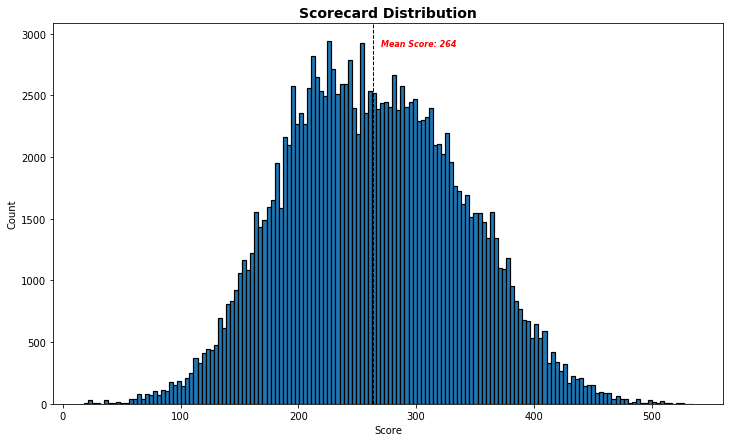

In [210]:
# Plot Scores
plt.figure(figsize=(12,7))

plt.hist(scorecard['score'],
         bins=150,
         edgecolor='black',
         linewidth=1.2)

plt.title('Scorecard Distribution', fontweight="bold", fontsize=14)
plt.axvline(scorecard['score'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.text(270, 2900, 'Mean Score: 264', color='red', fontweight='bold', style='italic', fontsize=8)
plt.xlabel('Score')
plt.ylabel('Count');